# Using Backtest as Hyper-parameters Tuning

In [1]:
import ssl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from orbit.models.dlt import DLTMAP
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.utils.features import make_fourier_series_df
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape

Let's use Turkish daily electricity demand data posted by Rob Hyndman.

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

# (c) Turkish electricity demand data.
# Daily data from 1 January 2000 to 31 December 2008.
raw_data = pd.read_csv("https://robjhyndman.com/data/turkey_elec.csv", header=None, names=['electricity'])
raw_data['date'] = pd.date_range(start='1/1/2000', end='31/12/2008', freq='D')

In [3]:
raw_data.head(5)

,electricity,date
0,12551.500000,2000-01-01
1,13377.041667,2000-01-02
2,15300.625000,2000-01-03
3,15582.750000,2000-01-04
4,15691.750000,2000-01-05


Use the `make_fourier_series_df` to create fourier series features to model dual seasonality.  We will use the series to capture yearly seasonality.

In [4]:
df, yr_cols = make_fourier_series_df(raw_data, 'date', 365.25, order=10)
m = df['electricity'][0]
df['y'] = np.log(df['electricity']/m)

In [5]:
df.head(3)

,electricity,date,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,fs_cos4,fs_sin4,...,fs_sin6,fs_cos7,fs_sin7,fs_cos8,fs_sin8,fs_cos9,fs_sin9,fs_cos10,fs_sin10,y
0,12551.500000,2000-01-01,-0.008601,0.999963,-0.017202,0.999852,-0.025801,0.999667,-0.034398,0.999408,...,0.998669,-0.060172,0.998188,-0.068755,0.997634,-0.077334,0.997005,-0.085906,0.996303,0.000000
1,13377.041667,2000-01-02,0.008601,0.999963,0.017202,0.999852,0.025801,0.999667,0.034398,0.999408,...,0.998669,0.060172,0.998188,0.068755,0.997634,0.077334,0.997005,0.085906,0.996303,0.063700
2,15300.625000,2000-01-03,0.025801,0.999667,0.051584,0.998669,0.077334,0.997005,0.103031,0.994678,...,0.988039,0.179645,0.983732,0.204966,0.978769,0.230151,0.973155,0.255182,0.966893,0.198053


Set a year long forecast with `test_size=365`.

In [6]:
test_size = 365

In [7]:
train_df=df[:-test_size]
test_df=df[-test_size:]

Let's train a DLTMAP model with the created fourier series to model yearly seasonality and we create weekly seasonality through `DLT` itself.

In [8]:
# instantiate a model
dlt = DLTMAP(
    date_col='date',
    response_col='y',
    regressor_col=yr_cols,
    seasonality=7,
#     level_sm_input=0.01,
#     slope_sm_input=0.01,
    regressor_sigma_prior=[10.0] * len(yr_cols),
)
dlt.fit(train_df)

In [9]:
pred_df = dlt.predict(test_df,decompose=True)
pred_df['prediction'] = np.exp(pred_df['prediction']) * m

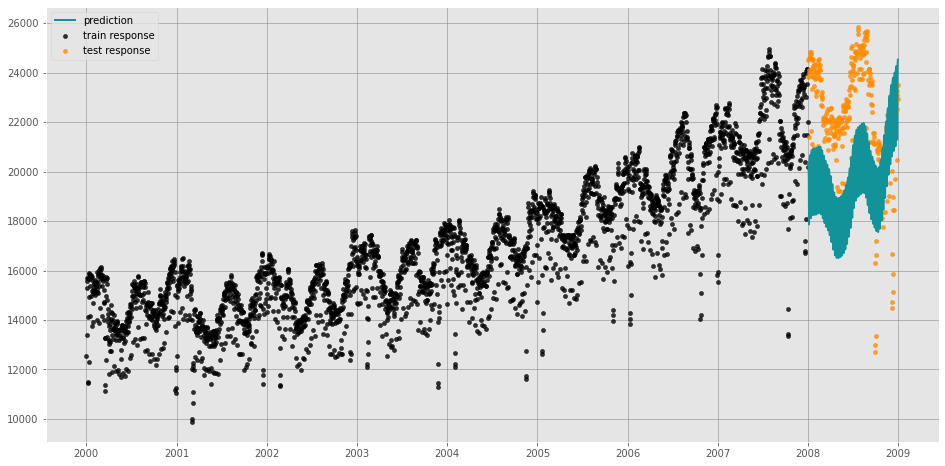

In [10]:
plot_predicted_data(train_df, pred_df, 'date', 'electricity', 'prediction', test_actual_df=test_df)

We can see that the performance is not that great.  It is mainly due to degeneracy of smooth seasonality vs. slow trend in our data set.
See https://en.wikipedia.org/wiki/Degeneracy_(mathematics) for explanation.

If we optimize our model using multiple predict horizon by backtest instead of 1-step error optimization in time-series model, we may find a better model

In [11]:
# make the grid search list of a dict
search_grid = []
candidate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]
for c in candidate:
    temp = {'level_sm_input': c, 'slope_sm_input': c} 
    search_grid.append(temp)

In [ ]:
best_metric = None
best_args = None
for args in search_grid:
    dlt = DLTMAP(
        date_col='date',
        response_col='y',
        regressor_col=yr_cols,
        seasonality=7,
        regressor_sigma_prior=[10.0] * len(yr_cols),
        **args,
    )
    bt = BackTester(
        model=dlt,
        df=df,
        min_train_len=365 * 5,
        incremental_len=360,
        forecast_len=test_size,
    )
    bt.fit_predict()
    # may want to assert we only retreive one value here (not array etc.)
    v = bt.score(metrics=[smape]).metric_values[0]
    print("Testing input set:")
    print(args)
    print("Performance metric:{:.3f}".format(v))
    if (best_metric is None) or (v < best_metric):
        best_metric = v
        best_args = args

In [ ]:
best_metric